## Modelagem - Predição usando Regressão Logística e Random Forest

In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import f1_score, precision_score, recall_score


In [101]:
df_limpo= pd.read_csv("dados/df_limpo_modelagem.csv")

print(df_limpo.isnull().sum())
print(df_limpo.isnull().sum())

df = df_limpo.copy()

tenure                      0
PhoneService                0
MultipleLines               0
InternetService             0
OnlineSecurity              0
OnlineBackup                0
DeviceProtection            0
TechSupport                 0
StreamingTV                 0
StreamingMovies             0
Contract                    0
PaperlessBilling            0
PaymentMethod               0
MonthlyCharges              0
TotalCharges                0
Churn                       0
cpf                         0
NPS                         0
gender                      0
SeniorCitizen               0
Partner                     0
Dependents                  0
churn_bin                   0
TotalServicosContratados    0
dtype: int64
tenure                      0
PhoneService                0
MultipleLines               0
InternetService             0
OnlineSecurity              0
OnlineBackup                0
DeviceProtection            0
TechSupport                 0
StreamingTV                

In [102]:
# PRÉ TRATATAMENTO 

X = df.drop(['churn_bin', 'Churn', 'cpf'], axis=1)
y = df['churn_bin']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

numeric_features = ['tenure', 'MonthlyCharges', 'NPS', 'TotalServicosContratados']
categorical_features = ['PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 
                       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 
                       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
                       'gender', 'Partner', 'Dependents']

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [103]:
# REGRESSÃO LOGÍSTICA
lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selector', SelectFromModel(
        RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
        threshold='median')),  
    ('classifier', LogisticRegression(
        max_iter=1000, 
        random_state=42, 
        class_weight='balanced',
        solver='liblinear'))
])

In [104]:
# RANDOM FOREST
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selector', SelectFromModel(
        RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
        threshold='median')),
    ('classifier', RandomForestClassifier(
        n_estimators=200, 
        random_state=42, 
        class_weight='balanced',
        max_depth=10))
])

In [105]:
# TREINO DOS MODELOS
lr_pipeline.fit(X_train, y_train)

rf_pipeline.fit(X_train, y_train)


,steps,"[('preprocessor', ...), ('feature_selector', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [106]:
def evaluate_model(model, model_name, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    print(f"\n=== {model_name} ===")
    print("Relatório de Classificação:")
    print(classification_report(y_test, y_pred))
    print(f"AUC-ROC: {roc_auc_score(y_test, y_proba):.4f}")
    
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matriz de Confusão - {model_name}')
    plt.ylabel('Verdadeiro')
    plt.xlabel('Predito')
    plt.show()
    
    return y_proba


=== Regressão Logística ===
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.90      0.76      0.82      1550
           1       0.53      0.77      0.63       561

    accuracy                           0.76      2111
   macro avg       0.72      0.76      0.73      2111
weighted avg       0.80      0.76      0.77      2111

AUC-ROC: 0.8441


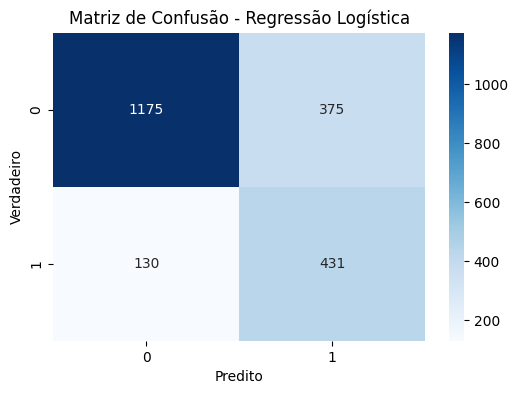


=== Random Forest ===
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.88      0.81      0.85      1550
           1       0.57      0.70      0.63       561

    accuracy                           0.78      2111
   macro avg       0.73      0.76      0.74      2111
weighted avg       0.80      0.78      0.79      2111

AUC-ROC: 0.8411


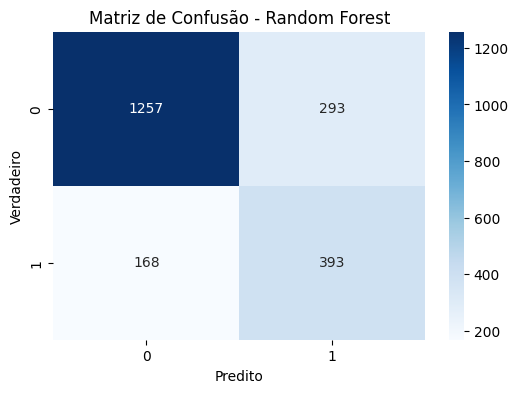

In [119]:
y_proba_lr = evaluate_model(lr_pipeline, "Regressão Logística", X_test, y_test)
y_proba_rf = evaluate_model(rf_pipeline, "Random Forest", X_test, y_test)


In [108]:
def get_selected_features(pipeline, categorical_features, numeric_features):
    
    onehot_columns = pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
    all_features = numeric_features + list(onehot_columns)
    
    selected_mask = pipeline.named_steps['feature_selector'].get_support()
    selected_features = np.array(all_features)[selected_mask]
    
    return selected_features

In [120]:
lr_features = get_selected_features(lr_pipeline, categorical_features, numeric_features)
rf_features = get_selected_features(rf_pipeline, categorical_features, numeric_features)

In [121]:
print("Regressão Logística")
print(lr_features)

print("Random Forest")
print(rf_features)

Regressão Logística
['tenure' 'MonthlyCharges' 'NPS' 'TotalServicosContratados'
 'InternetService_Fiber optic' 'OnlineSecurity_No' 'OnlineBackup_No'
 'DeviceProtection_No' 'TechSupport_No' 'Contract_Month-to-month'
 'Contract_One year' 'Contract_Two year' 'PaperlessBilling_No'
 'PaperlessBilling_Yes' 'PaymentMethod_Bank transfer (automatic)'
 'PaymentMethod_Credit card (automatic)' 'PaymentMethod_Electronic check'
 'gender_Female' 'gender_Male' 'Partner_No' 'Partner_Yes' 'Dependents_No'
 'Dependents_Yes']
Random Forest
['tenure' 'MonthlyCharges' 'NPS' 'TotalServicosContratados'
 'InternetService_Fiber optic' 'OnlineSecurity_No' 'OnlineBackup_No'
 'DeviceProtection_No' 'TechSupport_No' 'Contract_Month-to-month'
 'Contract_One year' 'Contract_Two year' 'PaperlessBilling_No'
 'PaperlessBilling_Yes' 'PaymentMethod_Bank transfer (automatic)'
 'PaymentMethod_Credit card (automatic)' 'PaymentMethod_Electronic check'
 'gender_Female' 'gender_Male' 'Partner_No' 'Partner_Yes' 'Dependents_No'
 'D

In [111]:
common_features = set(lr_features) & set(rf_features)
print(f"\nFeatures em comum entre os modelos: {len(common_features)}")
print(common_features)



Features em comum entre os modelos: 23
{np.str_('gender_Male'), np.str_('PaymentMethod_Electronic check'), np.str_('Partner_No'), np.str_('Contract_Two year'), np.str_('MonthlyCharges'), np.str_('TechSupport_No'), np.str_('TotalServicosContratados'), np.str_('Dependents_Yes'), np.str_('OnlineSecurity_No'), np.str_('PaperlessBilling_Yes'), np.str_('DeviceProtection_No'), np.str_('PaperlessBilling_No'), np.str_('PaymentMethod_Credit card (automatic)'), np.str_('Contract_One year'), np.str_('tenure'), np.str_('gender_Female'), np.str_('Partner_Yes'), np.str_('PaymentMethod_Bank transfer (automatic)'), np.str_('NPS'), np.str_('InternetService_Fiber optic'), np.str_('Dependents_No'), np.str_('OnlineBackup_No'), np.str_('Contract_Month-to-month')}


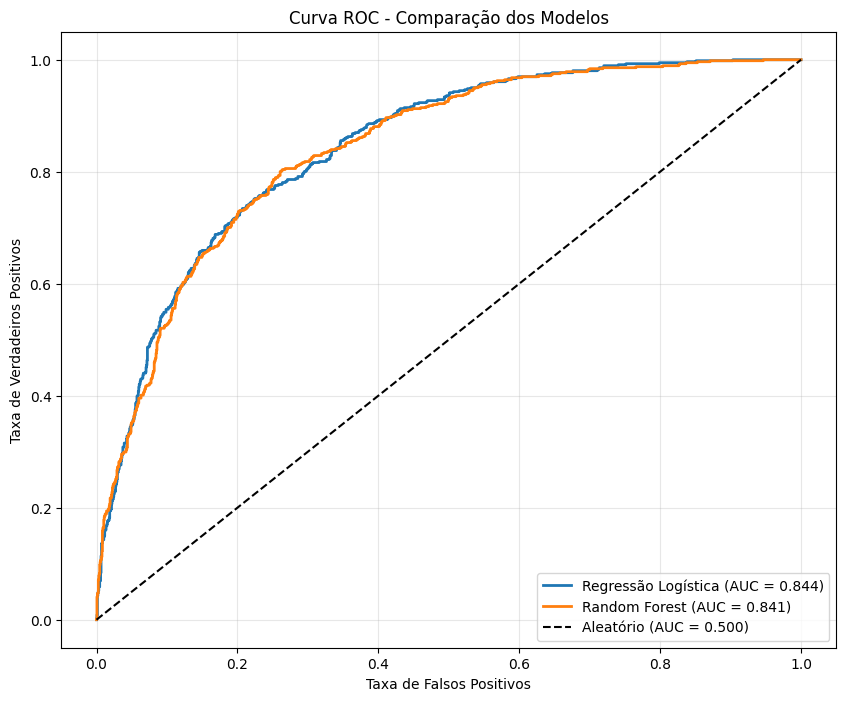

In [112]:
# CURVA ROC

plt.figure(figsize=(10, 8))


fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)
plt.plot(fpr_lr, tpr_lr, label=f'Regressão Logística (AUC = {roc_auc_lr:.3f})', linewidth=2)

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.3f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Aleatório (AUC = 0.500)')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC - Comparação dos Modelos')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()

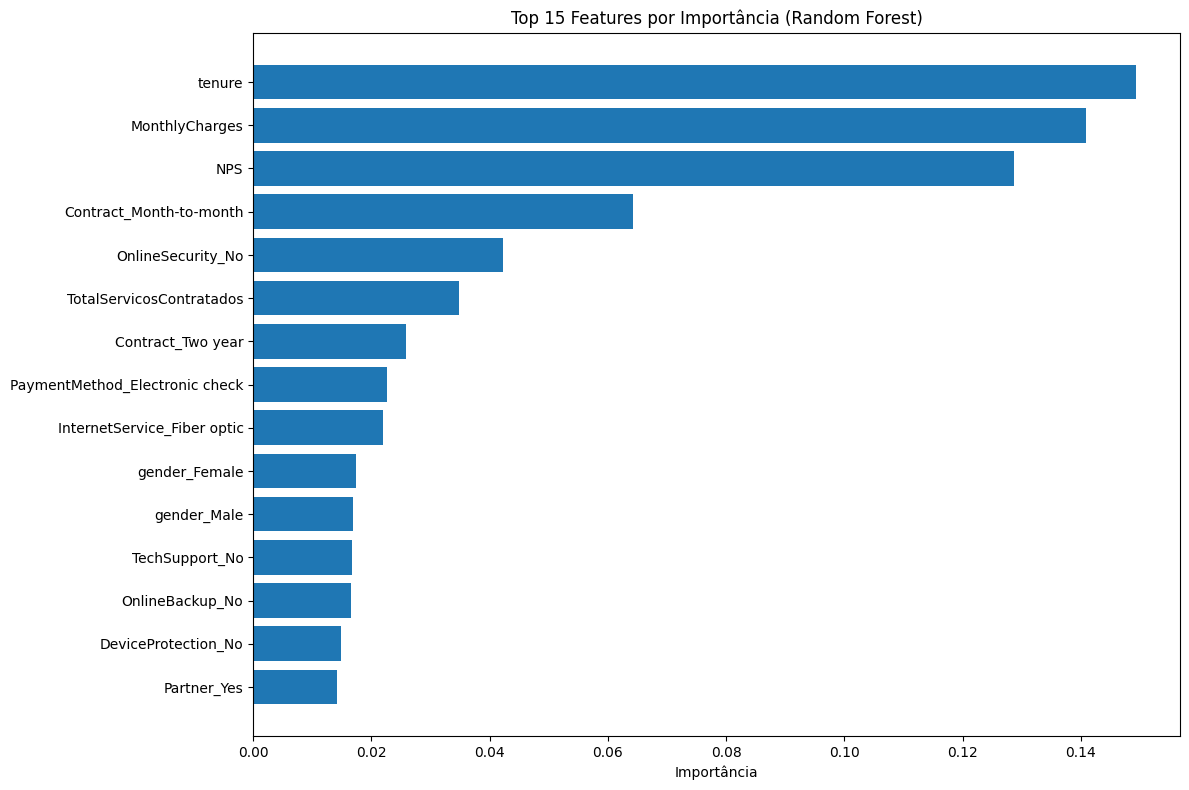

In [113]:
#  PRINCIPAIS FEATURES RANDOM FOREST
rf_importances = rf_pipeline.named_steps['feature_selector'].estimator_.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': numeric_features + list(rf_pipeline.named_steps['preprocessor']
                                    .named_transformers_['cat']
                                    .named_steps['onehot']
                                    .get_feature_names_out(categorical_features)),
    'Importance': rf_importances
})

feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'][:15], feature_importance_df['Importance'][:15])
plt.title('Top 15 Features por Importância (Random Forest)')
plt.xlabel('Importância')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [114]:
# F1-Score, Precisão, Recall para cada modelo

print("F1-Score LR:", f1_score(y_test, y_pred_lr))
print("F1-Score RF:", f1_score(y_test, y_pred_rf))
print("Precisão LR:", precision_score(y_test, y_pred_lr))
print("Precisão RF:", precision_score(y_test, y_pred_rf))

F1-Score LR: 0.6138996138996139
F1-Score RF: 0.5529767911200807
Precisão LR: 0.6694736842105263
Precisão RF: 0.6372093023255814


In [122]:

novos_dados = X_test.copy()

previsoes = lr_pipeline.predict(novos_dados)
probabilidades = lr_pipeline.predict_proba(novos_dados)

resultados = novos_dados.copy()
resultados['Previsao_Churn'] = previsoes
resultados['Probabilidade_Churn'] = probabilidades[:, 1] 
resultados['Probabilidade_Nao_Churn'] = probabilidades[:, 0] 

print("Primeiras 10 previsões:")
print(resultados[['Previsao_Churn', 'Probabilidade_Churn', 'Probabilidade_Nao_Churn']].head(10))

Primeiras 10 previsões:
      Previsao_Churn  Probabilidade_Churn  Probabilidade_Nao_Churn
4082               0             0.121487                 0.878513
2005               0             0.063210                 0.936790
2529               1             0.831522                 0.168478
5655               0             0.048160                 0.951840
1970               0             0.034465                 0.965535
2108               1             0.925010                 0.074990
1497               0             0.119532                 0.880468
3932               1             0.595263                 0.404737
5004               1             0.659847                 0.340153
7024               0             0.338889                 0.661111



📊 Estatísticas das Previsões:
Total de clientes previstos: 2111
Clientes previstos com Churn: 806 (38.2%)
Clientes previstos sem Churn: 1305 (61.8%)


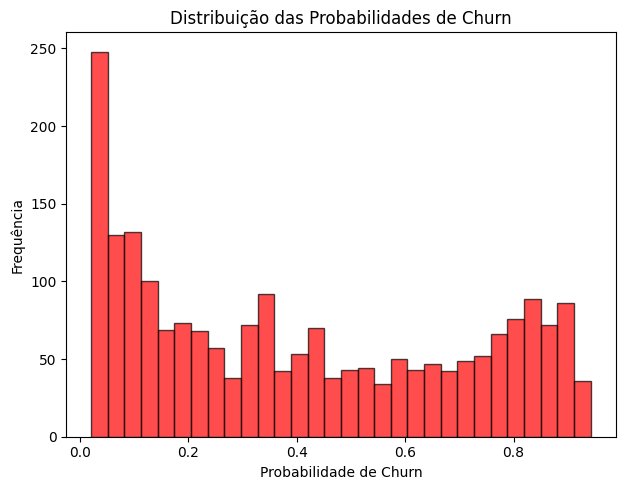

In [116]:
print("\n📊 Estatísticas das Previsões:")
print(f"Total de clientes previstos: {len(previsoes)}")
print(f"Clientes previstos com Churn: {previsoes.sum()} ({previsoes.sum()/len(previsoes)*100:.1f}%)")
print(f"Clientes previstos sem Churn: {len(previsoes) - previsoes.sum()} ({(1 - previsoes.sum()/len(previsoes))*100:.1f}%)")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(probabilidades[:, 1], bins=30, alpha=0.7, color='red', edgecolor='black')
plt.title('Distribuição das Probabilidades de Churn')
plt.xlabel('Probabilidade de Churn')
plt.ylabel('Frequência')

#plt.subplot(1, 2, 2)
#plt.boxplot(probabilidades[:, 1])
#plt.title('Boxplot das Probabilidades de Churn')
#plt.ylabel('Probabilidade')

plt.tight_layout()
plt.show()

In [117]:

install_cost = 600.0                     # custo de instalação (R$)
margin_rate = 0.6                        # margem sobre MonthlyCharges
horizon_meses = 6                        # margem em risco considerada
offer_cost = 50.0                        # custo médio da oferta de retenção (R$)
uplift_retencao = 0.30                   

df_test = df.loc[X_test.index].copy()

df_test["margem_mensal"] = df_test["MonthlyCharges"] * margin_rate
df_test["margem_mensal"] = df_test["margem_mensal"].clip(lower=0.01)  

# Breakeven e instalação não amortizada
df_test["meses_breakeven"] = np.ceil(install_cost / df_test["margem_mensal"])
df_test["inst_nao_amortizada"] = np.maximum(0.0, install_cost - df_test["tenure"] * df_test["margem_mensal"])

# Valor em risco (instalação + alguns meses de margem)
df_test["valor_em_risco"] = df_test["inst_nao_amortizada"] + horizon_meses * df_test["margem_mensal"]


p = pd.Series(y_proba_lr, index=df_test.index)   
df_test["p_churn"] = p

df_test["EV_intervencao"] = df_test["p_churn"] * uplift_retencao * df_test["valor_em_risco"] - offer_cost

df_test["tratar"] = df_test["EV_intervencao"] > 0

prioridade = df_test[df_test["tratar"]].copy()
prioridade = prioridade.sort_values("EV_intervencao", ascending=False)

cols_show = ["tenure","MonthlyCharges","margem_mensal","meses_breakeven","inst_nao_amortizada",
             "valor_em_risco","p_churn","EV_intervencao"]
print("TOP 20 clientes para tratar (ordem por EV):")
display(prioridade[cols_show].head(20))



TOP 20 clientes para tratar (ordem por EV):


,tenure,MonthlyCharges,margem_mensal,meses_breakeven,inst_nao_amortizada,valor_em_risco,p_churn,EV_intervencao
1289,1,95.10,57.06,11.0,542.94,885.30,0.931892,197.501280
1498,1,93.30,55.98,11.0,544.02,879.90,0.924815,194.123315
1464,1,93.85,56.31,11.0,543.69,881.55,0.921031,193.580487
1584,1,91.30,54.78,11.0,545.22,873.90,0.919794,191.142433
1852,1,89.30,53.58,12.0,546.42,867.90,0.922087,190.083891
2092,1,85.70,51.42,12.0,548.58,857.10,0.926064,188.118941
2004,1,86.60,51.96,12.0,548.04,859.80,0.922878,188.047148
1757,1,89.90,53.94,12.0,546.06,869.70,0.902917,185.580112
1883,1,89.10,53.46,12.0,546.54,867.30,0.904016,185.215920
2263,1,84.60,50.76,12.0,549.24,853.80,0.912536,183.737048


Ficou sem explicação lógica, tentar modelar outro dia, se der tempo.

In [118]:
import statsmodels.api as sm


X_train_tx = lr_pipeline.named_steps['preprocessor'].transform(X_train)
X_train_sel = lr_pipeline.named_steps['feature_selector'].transform(X_train_tx)


ohe = lr_pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
onehot_cols = ohe.get_feature_names_out(categorical_features)
all_cols = np.array(numeric_features + list(onehot_cols))
sel_names = all_cols[lr_pipeline.named_steps['feature_selector'].get_support()]

X_sm = sm.add_constant(X_train_sel, has_constant="add")
model = sm.Logit(y_train.values, X_sm).fit(disp=0)
summ = model.summary2().tables[1] 
summ.index = ["const"] + list(sel_names)
display(summ.sort_values("P>|z|").head(20))


/home/thiago/resolucao_case_bradesco/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
tenure,-0.528124,1.199614e-01,-4.402447e+00,0.000011,-7.632435e-01,-2.930036e-01
OnlineSecurity_No,0.508117,1.430365e-01,3.552357e+00,0.000382,2.277704e-01,7.884633e-01
NPS,-0.458572,1.411388e-01,-3.249083e+00,0.001158,-7.351986e-01,-1.819447e-01
InternetService_Fiber optic,1.341948,4.241492e-01,3.163858e+00,0.001557,5.106306e-01,2.173265e+00
TotalServicosContratados,0.881550,3.009675e-01,2.929054e+00,0.003400,2.916645e-01,1.471435e+00
TechSupport_No,0.363148,1.423053e-01,2.551895e+00,0.010714,8.423484e-02,6.420612e-01
MonthlyCharges,-0.965772,4.096504e-01,-2.357551e+00,0.018396,-1.768672e+00,-1.628716e-01
DeviceProtection_No,0.265074,1.194417e-01,2.219276e+00,0.026468,3.097263e-02,4.991753e-01
OnlineBackup_No,0.262024,1.223308e-01,2.141930e+00,0.032199,2.226007e-02,5.017880e-01
PaymentMethod_Electronic check,0.241947,1.199680e-01,2.016764e+00,0.043720,6.814128e-03,4.770800e-01
